In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from vega_datasets import data

In [2]:
df = pd.read_csv('student-mat.csv')

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Final project for DS 2.1 - Machine Learning - Andrey Novichkov
## Dataset - Student Alcahol Consumption (Kaggle)

**Questions I want to Answer:**
- What are the trends amongs male vs female students
- What are the overall correlations between the different features?
- See if Alcahol affects final grades!
- What is the one feature that is the best predictor for the final grade(random forest)
- Build linear regression model that predicts grades
- Build classification model that predicts pass/fail of a student
- PCA to improve models
- K-means clustering to see if we have clusters of pass/fail students
- Build Decision Tree for model

In [4]:
df.shape

(395, 33)

In [5]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [6]:
feature_cols_small = ['sex', 'age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences', 'G3']
feature_cols_big = ['sex', 'age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences', 'romantic', 'famrel', 'health', 'G1', 'G2', 'G3']

## Let's get some general stats on male vs female datapoints
This is just to get a sense of the data

In [7]:
sml_feature_df = df[feature_cols_small]
males = sml_feature_df[sml_feature_df['sex'] == 'M']
females = sml_feature_df[sml_feature_df['sex'] == 'F']

In [8]:
sml_feature_df[:2]

,sex,age,studytime,failures,goout,Dalc,Walc,absences,G3
0,F,18,2,0,4,1,1,6,6
1,F,17,2,0,3,1,1,4,6


In [9]:
male_means = males.mean()
data = {
    'feature': male_means.index,
    'average': male_means.values
}
male_df = pd.DataFrame(data)
male_df['sex'] = 'male'

female_means = females.mean()
data = {
    'feature': female_means.index,
    'average': female_means.values
}
female_df = pd.DataFrame(data)
female_df['sex'] = 'female'

avg_feature_df = pd.concat([female_df, male_df])

In [10]:
alt.Chart(avg_feature_df).mark_bar().encode(
    x='sex:O',
    y='average:Q',
    color='sex:O',
    column='feature:O'
)

alt.Chart(...)

## Do we have correlation among features?
To see if we want to do PCA in the future

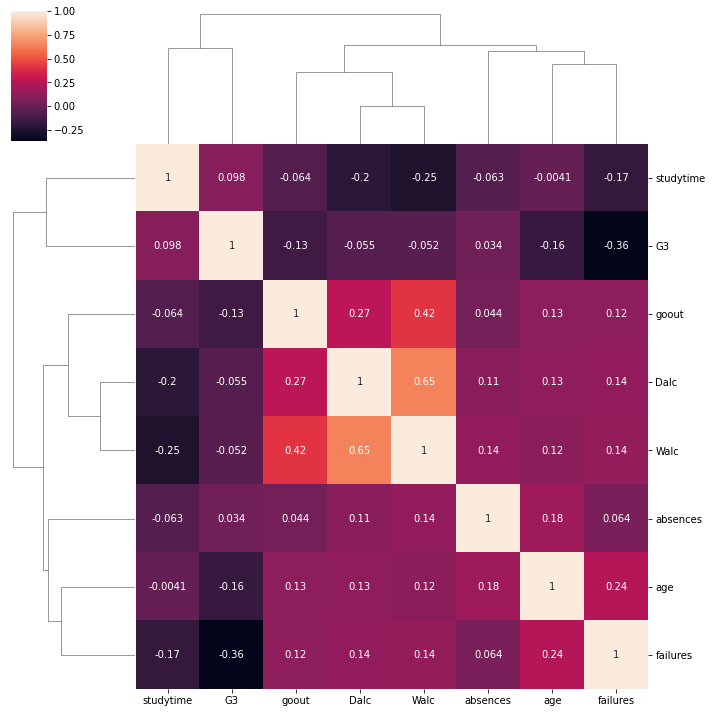

In [11]:
_= sns.clustermap(data=sml_feature_df.corr(), annot=True)

**As we can see, no big correlation here which is good!**

## Let's see if we can build a good Linear Regression model on the small feature dataset

In [12]:
sml_feature_df[:1]

,sex,age,studytime,failures,goout,Dalc,Walc,absences,G3
0,F,18,2,0,4,1,1,6,6


In [13]:
feature_cols = ['age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences']
X = sml_feature_df[feature_cols]
y = sml_feature_df['G3']

I don't think there is a point in normalizing the data, it is all very similar in value

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 24.597125856592157
r^2 score: 0.13109328407319654


**That is a pretty bad model! LOL**  
Let's see if normalizing the data will actually help! 

In [15]:
from sklearn.preprocessing import normalize

X_norm = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 23.431019388434272
r^2 score: 0.17228662298504827


**Ok well, it improved a little bit, but not by that much!**  
Let's see if giving it more features will help!
Let's also encode the non-numerical features!

In [16]:
big_feature_df = df[feature_cols_big]
big_feature_df[:1]

,sex,age,studytime,failures,goout,Dalc,Walc,absences,romantic,famrel,health,G1,G2,G3
0,F,18,2,0,4,1,1,6,no,4,3,5,6,6


In [17]:
big_feature_df = pd.get_dummies(big_feature_df)
big_feature_df[:1]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G1,G2,G3,sex_F,sex_M,romantic_no,romantic_yes
0,18,2,0,4,1,1,6,4,3,5,6,6,1,0,1,0


In [18]:
y = big_feature_df['G3']
X = big_feature_df.drop(['G3', 'G2', 'G1'], axis=1)

In [19]:
X_norm = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 21.8997194674222
r^2 score: 0.22638061726808256


**A little better.. But ehhh. Maybe there just isnt a good correlation between these features and the final grade..**

## Let's at least try PCA to see if we can improve the model even more!
This way we can reduce the number of features just to 2 or 3, instead of 11

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_red = pca.fit_transform(X_norm)
X_red[:2]

array([[ 0.03878894, -0.06691985],
       [-0.04997754, -0.07965824]])

2      1
3      1
4      1
5      1
6      1
      ..
388    0
389    0
390    0
392    0
394    0
Name: result, Length: 395, dtype: int64

In [151]:
pca_df = pd.DataFrame(X_red, columns=['pca1', 'pca2'])
pca_df['Infectivity'] = [ pass]

,pca1,pca2
0,0.282262,0.021040
1,-0.138726,-0.036717
2,-0.040679,-0.002978
3,0.243445,-0.005227
4,-0.251235,-0.030014
...,...,...
390,-0.244632,-0.104953
391,-0.242974,-0.055740
392,0.202272,0.101334
393,-0.118370,0.019724


In [21]:
data = {
    'pca1': X_red[:,0],
    'pca2': X_red[:,1]
}
pca_df = pd.DataFrame(data)

alt.Chart(pca_df).mark_circle(size=60).encode(
    x='pca1',
    y='pca2'
).interactive()

alt.Chart(...)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_red,y, test_size=.25, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print(f'MSE error: {mean_squared_error(y_test, y_pred)}')
print(f'r^2 score: {r2_score(y_test, y_pred)}')

MSE error: 27.85960790687035
r^2 score: 0.01584434886812547


**Well... that definetly did not make it any better :)**

## Let's see if we can now classify students into pass/fail groups and see if we can build a good classification model instead of a regression one! 

In [23]:
big_feature_df = df[feature_cols_big]
big_feature_df = big_feature_df.drop(['G1', 'G2'], axis=1)
big_feature_df = pd.get_dummies(big_feature_df)
big_feature_df[:1]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G3,sex_F,sex_M,romantic_no,romantic_yes
0,18,2,0,4,1,1,6,4,3,6,1,0,1,0


**Let's say that if G3 is >= 10 the person is passing, but if < 10 person is failing**

In [123]:
pass_df = big_feature_df[big_feature_df['G3'] >= 10]
pass_df['result'] = 1
fail_df = big_feature_df[big_feature_df['G3'] < 10]
fail_df['result'] = 0
big_feature_df = pd.concat([pass_df, fail_df])
big_feature_df[:1]

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G3,sex_F,sex_M,romantic_no,romantic_yes,result
2,15,2,3,2,2,3,10,4,3,10,1,0,1,0,1


In [124]:
big_feature_df['result'].value_counts()

1    265
0    130
Name: result, dtype: int64

## Let's start with SVM (Support Vector Machine)

First we want to get the best hyper parameters using Grid Search

In [125]:
y = big_feature_df['result']
X = big_feature_df.drop(['G3', 'result'], axis=1)
X_norm = normalize(X)

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_

svc_param_selection(X_norm, y, 5)

{'C': 10, 'gamma': 0.001}

**Perfect! Now we can use 10 as our C parameters for best results!**

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25, random_state=2)

svm_clf = svm.SVC(kernel='linear', C=10)

Since we are now doing classification problems, we can use the confusion matrix to calculate things like accuracy, recall and f1 score. But we can also use cross validation to see how good our model is! 

In [136]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator=svm_clf, X=X_norm, y=y, cv=5, scoring='accuracy')
mean_accuracy = accuracies.mean()

print(f'All accuracies: {accuracies}')
print(f'Mean accuracy: {mean_accuracy}')

f1_scores = cross_val_score(estimator=svm_clf, X=X_norm, y=y, cv=5, scoring='f1')
mean_f1_score = f1_scores.mean()

print(f'All f1 scores: {f1_scores}')
print(f'Mean f1 score: {mean_f1_score}')

All accuracies: [0.70886076 0.78481013 0.6835443  0.69620253 0.6835443 ]
Mean accuracy: 0.7113924050632912
All f1 scores: [0.81889764 0.85470085 0.80314961 0.81538462 0.80314961]
Mean f1 score: 0.8190564640958342


**Hmm.. This looks like a pretty good model! F1 score is pretty high, but accuracy is average..**

In [141]:
from sklearn.metrics import confusion_matrix, recall_score

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{c_matrix}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1_score: {f1_score(y_test, y_pred)}')

Confusion matrix:
[[ 7 22]
 [ 1 69]]
Recall score: 0.9857142857142858
Accuracy: 0.7676767676767676
F1_score: 0.8571428571428571


Ok... So we are getting a lot of False Positives, which means that when the student actually did not pass, we are saying that he/she did. I guess this is not critical, it would be worse if the student passed and we would have been saying that they didnt...

**Let's try PCA and see what happens, do some dimensionality REDUCTION!**

In [142]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(X_norm)

X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=.25, random_state=2)
svm_clf = svm.SVC(kernel='linear', C=10)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{c_matrix}')
print(f'Recall score: {recall_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'F1_score: {f1_score(y_test, y_pred)}')

Confusion matrix:
[[ 0 29]
 [ 0 70]]
Recall score: 1.0
Accuracy: 0.7070707070707071
F1_score: 0.8284023668639052


For some reason we are not getting any false/true negatives at all... Interesting.. will need to investigate

## Let's try building a decision tree!

In [143]:
big_feature_df[:1]

,age,studytime,failures,goout,Dalc,Walc,absences,famrel,health,G3,sex_F,sex_M,romantic_no,romantic_yes,result
2,15,2,3,2,2,3,10,4,3,10,1,0,1,0,1


In [144]:
from sklearn.tree import DecisionTreeClassifier

y = big_feature_df['result']
X = big_feature_df.drop(['G3', 'result'], axis=1)

X_norm = normalize(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=.25, random_state=0)

d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [145]:
accuracies = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='accuracy')
mean_accuracy = accuracies.mean()

print(f'All accuracies: {accuracies}')
print(f'Mean accuracy: {mean_accuracy}')

f1_scores = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='f1')
mean_f1_score = f1_scores.mean()

print(f'All f1 scores: {f1_scores}')
print(f'Mean f1 score: {mean_f1_score}')

All accuracies: [0.60759494 0.56962025 0.59493671 0.63291139 0.63291139]
Mean accuracy: 0.6075949367088608
All f1 scores: [0.752      0.67326733 0.67307692 0.73584906 0.72      ]
Mean f1 score: 0.710838661282674


**Ok! A little bit worse than SVM but f1 score not that bad**

In [146]:
from sklearn.metrics import accuracy_score, f1_score

d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)

print(f'Confusion matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'F1 score: {f1_score(y_test, y_pred)}')

Confusion matrix:
 [[11 21]
 [16 51]]
Accuracy score: 0.6262626262626263
F1 score: 0.7338129496402879


### Let's visualize this decision tree!

In [147]:
from dtreeviz.trees import *

In [148]:
X_sample = np.array(X_norm[np.random.randint(0, X_norm.shape[0]),:])
feature_names = X.columns
class_names = [0, 1]

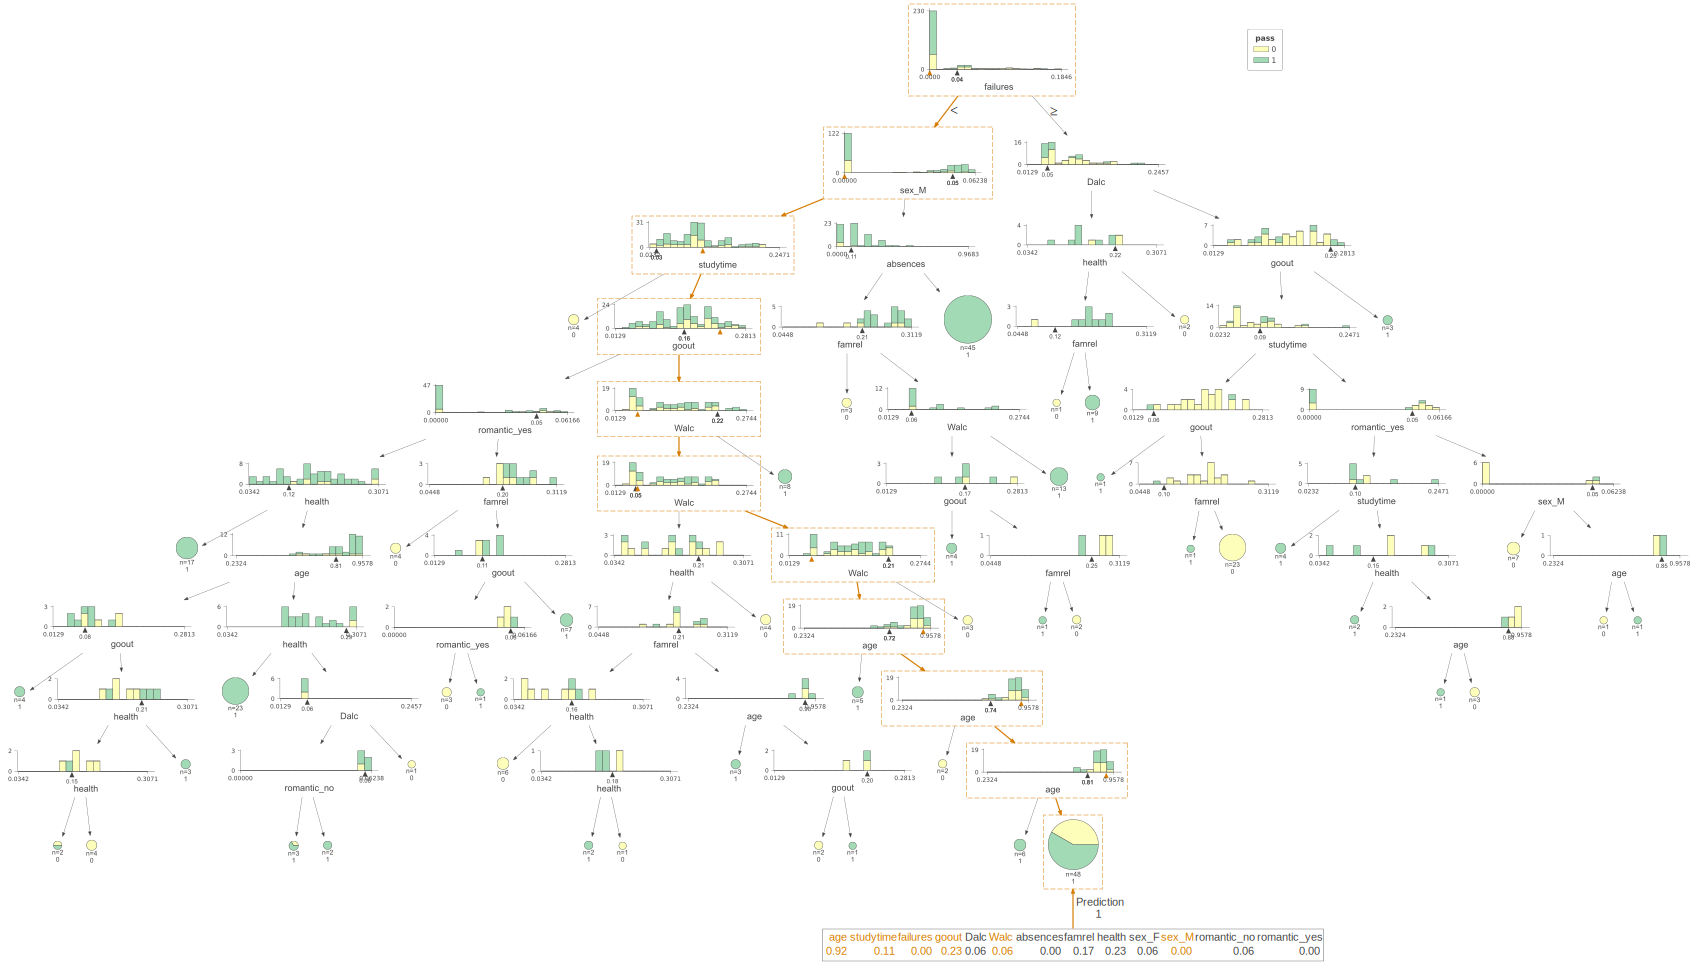

In [149]:
viz = dtreeviz(d_tree,
               X_train,
               y_train,
               target_name='pass',  # this name will be displayed at the leaf node
               class_names=class_names,
               feature_names=feature_names,
               X=X_sample
              )

viz

**Let's see if reducing depth can increase our accuracy and f1 score!**

In [120]:
d_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)

accuracies = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='accuracy')
mean_accuracy = accuracies.mean()

print(f'All accuracies: {accuracies}')
print(f'Mean accuracy: {mean_accuracy}')

f1_scores = cross_val_score(estimator=d_tree, X=X_norm, y=y, cv=5, scoring='f1')
mean_f1_score = f1_scores.mean()

print(f'All f1 scores: {f1_scores}')
print(f'Mean f1 score: {mean_f1_score}')

All accuracies: [0.64556962 0.70886076 0.65822785 0.64556962 0.63291139]
Mean accuracy: 0.6582278481012658
All f1 scores: [0.17142857 0.45454545 0.26315789 0.46153846 0.48275862]
Mean f1 score: 0.366685800587797


### Not really! LOL

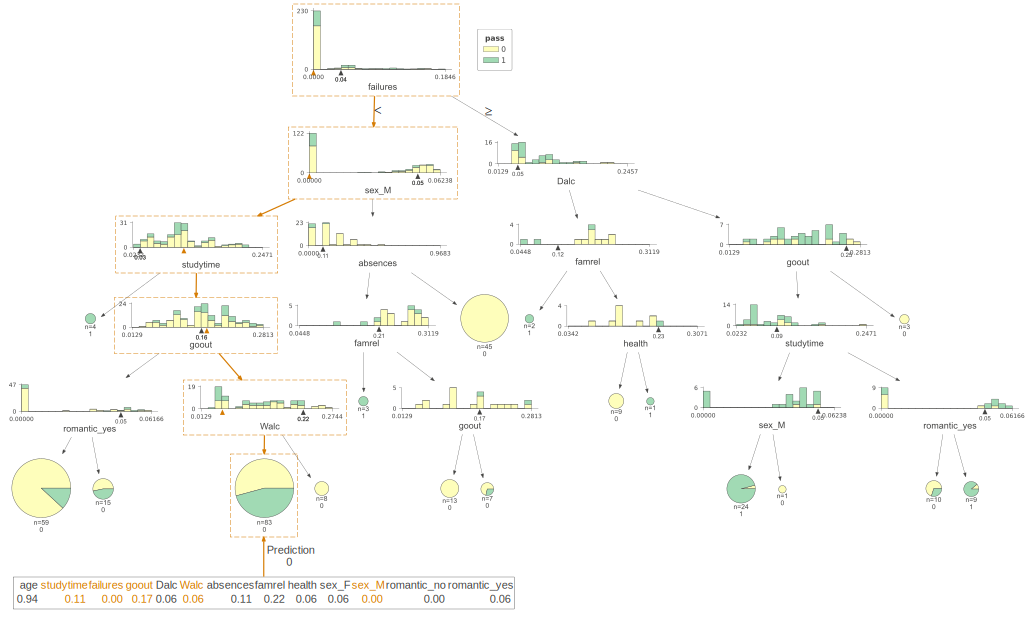

In [122]:
d_tree.fit(X_train, y_train)

viz = dtreeviz(d_tree,
               X_train,
               y_train,
               target_name='pass',  # this name will be displayed at the leaf node
               class_names=class_names,
               feature_names=feature_names,
               X=X_sample
              )

viz

In [59]:
X_train.shape

(296, 13)

In [61]:
y_train.shape

(296,)

array([0.89165745, 0.11888766, 0.        , 0.17833149, 0.05944383,
       0.11888766, 0.11888766, 0.29721915, 0.17833149, 0.        ,
       0.05944383, 0.05944383, 0.        ])

In [ ]:
svm_clf.fit(X_train, y_train)

In [ ]:
y_pred = svm_clf.predict(X_test)

In [64]:
df['sex'].value_counts()

F    208
M    187
Name: sex, dtype: int64

In [65]:
m_f_features = ['sex', 'age', 'studytime', 'failures', 'goout', 'Dalc', 'Walc', 'absences', 'G3']

In [66]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [60]:
feature_df = df[m_f_features]
feature_df.head()

,sex,age,studytime,failures,goout,Dalc,Walc,absences,G3
0,F,18,2,0,4,1,1,6,6
1,F,17,2,0,3,1,1,4,6
2,F,15,2,3,2,2,3,10,10
3,F,15,3,0,2,1,1,2,15
4,F,16,2,0,2,1,2,4,10


In [61]:
feature_df.dtypes

sex          object
age           int64
studytime     int64
failures      int64
goout         int64
Dalc          int64
Walc          int64
absences      int64
G3            int64
dtype: object

In [63]:
pass_df = feature_df[feature_df['G3'] >= 10]
pass_df['result'] = 'pass'
fail_df = feature_df[feature_df['G3'] < 10]
fail_df['result'] = 'fail'
feature_df = pd.concat([pass_df, fail_df])
feature_df

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,sex,age,studytime,failures,goout,Dalc,Walc,absences,G3,result
2,F,15,2,3,2,2,3,10,10,pass
3,F,15,3,0,2,1,1,2,15,pass
4,F,16,2,0,2,1,2,4,10,pass
5,M,16,2,0,2,1,2,10,15,pass
6,M,16,2,0,4,1,1,0,11,pass
...,...,...,...,...,...,...,...,...,...,...
388,F,18,2,0,4,1,1,0,8,fail
389,F,18,2,1,1,1,1,0,0,fail
390,M,20,2,2,4,4,5,11,9,fail
392,M,21,1,3,3,3,3,3,7,fail


In [65]:
alt.Chart(feature_df).mark_bar().encode(
    x='age:N',
    y='mean(Dalc):Q',
    color='sex:N',
    column='result:N'
)

alt.Chart(...)

In [66]:
alt.Chart(feature_df).mark_bar().encode(
    x='sex:N',
    y='mean(Dalc):Q',
    color='age:N',
    column='result:N'
)

alt.Chart(...)

In [19]:
import altair as alt
from vega_datasets import data

source = data.barley()

source

,yield,variety,year,site
0,27.00000,Manchuria,1931,University Farm
1,48.86667,Manchuria,1931,Waseca
2,27.43334,Manchuria,1931,Morris
3,39.93333,Manchuria,1931,Crookston
4,32.96667,Manchuria,1931,Grand Rapids
...,...,...,...,...
115,58.16667,Wisconsin No. 38,1932,Waseca
116,47.16667,Wisconsin No. 38,1932,Morris
117,35.90000,Wisconsin No. 38,1932,Crookston
118,20.66667,Wisconsin No. 38,1932,Grand Rapids


In [18]:
alt.Chart(source).mark_bar().encode(
    x='year:O',
    y='sum(yield):Q',
    color='year:N',
    column='site:N'
)

alt.Chart(...)

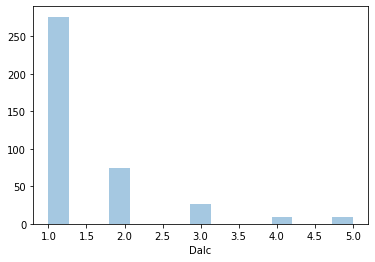

In [10]:
_= sns.distplot(df['Dalc'], kde=False)

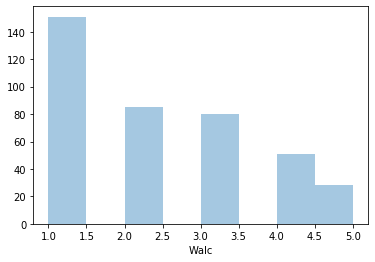

In [11]:
_= sns.distplot(df['Walc'], kde=False)

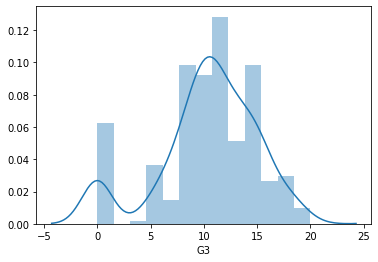

In [13]:
_= sns.distplot(df['G3'], kde=True)

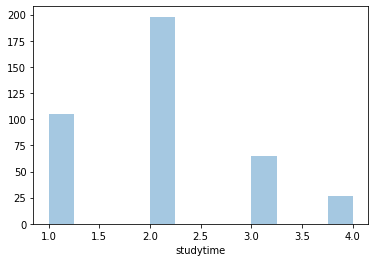

In [14]:
_= sns.distplot(df['studytime'], kde=False)

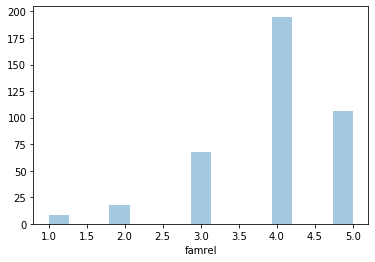

In [15]:
_= sns.distplot(df['famrel'], kde=False)

ValueError: could not convert string to float: 'GP'

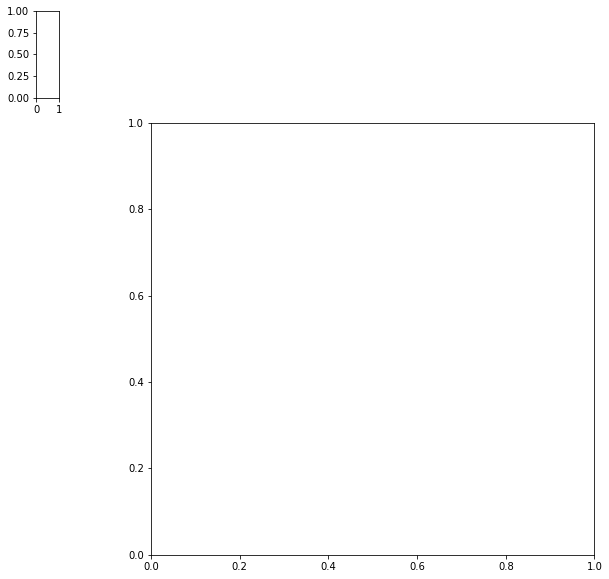

In [16]:
sns.clustermap(df)